In [7]:
"""
This part of code is the Deep Q Network (DQN) brain.
view the tensorboard picture about this DQN structure on: https://morvanzhou.github.io/tutorials/machine-learning/reinforcement-learning/4-3-DQN3/#modification
View more on my tutorial page: https://morvanzhou.github.io/tutorials/
Using:
PyTorch
"""

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F


# np.random.seed(1)
# USE_CUDA = torch.cuda.is_available()


# Deep Q Network off-policy
class DQN(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(DQN, self).__init__()
        self.line1 = nn.Linear(num_inputs, 64)
        self.line2 = nn.Linear(64, 32)
        self.line3 = nn.Linear(32, num_outputs)

    def forward(self, x):
        x = torch.sigmoid(self.line1(x))
        x = F.relu(self.line2(x))
        x = self.line3(x)
        return x



import heapq
import random
import numpy as np


class BikeNet():
    def __init__(self, N, A, R, Q, repair, warmup_time, run_time, start_position=0):
        self.N = N
        self.A = A
        self.R = R
        self.Q = Q
        self.repair = repair
        self.warmup_time = warmup_time
        self.run_time = run_time
        self.time_limit = warmup_time + run_time
        self.car = start_position
        self.edge = int(self.A**0.5)
        self.areas = list(range(A + 1))

        self.c = 0

        self.reset()

    def reset(self):
        self.T = 0
        self.c = 0
        self.carrier_position = self.car
        self.state = [int(self.N / self.A)] * self.A + [0] * self.A
        self.scheduler = []
        heapq.heapify(self.scheduler)
        for i in range(self.A):
            heapq.heappush(self.scheduler, [random.expovariate(self.R[i][0]), -1, i])
        heapq.heapify(self.scheduler)
        return np.array(self.state.copy())

    def warmup(self, rl):
        s = self.reset()

        while self.T < self.warmup_time:
            action = random.randint(0,3)
            result = self.step(action, 0)
            s_, served = result[0], result[1]
            rl.store_transition(s, action, served, s_)
            s = s_
        self.T = self.warmup_time
        return np.array(s.copy())


    def step(self, action, not_warm):
        rewards = 0
        cus = 0
        # time for carrier to take the action and repair one bicycle
        t = max((abs(self.carrier_position % (self.edge) - action % (self.edge)) + abs(
            self.carrier_position // (self.edge) - action // (self.edge))) * 0.5, 0.5)
        if self.state[action + self.A] > 0:
            t_cursor = self.T + t + self.repair
        else:
            t_cursor = self.T + t

        event = self.scheduler[0]
        self.T, kind, location = event[0], event[1], event[2]

        # update the atate of QN during the tansformation time
        while self.T < t_cursor:
            # 车到达
            if kind == 1:
                self.state[location] += 1
                heapq.heappop(self.scheduler)
            else:
                cus+=1
                # 顾客到达
                if self.state[location] == 0:  # 但没车
                    rewards -= 1
                    heapq.heappop(self.scheduler)
                else:
                    target = np.random.choice(self.areas, 1, p=self.Q[location])[0]
                    if target == self.A:  # 顾客到达，发现是坏车
                        self.state[location] -= 1
                        self.state[location + self.A] += 1
                        continue
                    else:  # 顾客到达，顺利骑行
                        self.state[location] -= 1
                        heapq.heappop(self.scheduler)
                        next_time = random.expovariate(self.R[location][1]) + self.T
                        if next_time <= self.time_limit:
                            heapq.heappush(self.scheduler, [next_time, 1, target])
                next_time = random.expovariate(self.R[location][0]) + self.T
                if next_time <= self.time_limit:
                    heapq.heappush(self.scheduler, [next_time, -1, location])

            if self.scheduler:
                event = self.scheduler[0]
                self.T, kind, location = event[0], event[1], event[2]
            else:
                break

        #print(cus)

        if not_warm == 1:
            if self.state[action + self.A] > 0:
                self.state[self.carrier_position] += 1
                self.state[self.carrier_position + self.A] -= 1

        self.carrier_position = action
        self.T = t_cursor

        s_ = np.array(self.state.copy())

        if self.T <= self.time_limit and self.scheduler:
            return s_, cus + rewards, 0
        else:
            return s_, cus + rewards, 1


import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
#from NeuralNetwork import DQN

class Train():
    def __init__(
            self,
            n_actions,
            n_features,
            n_episodes,
            learning_rate=0.01,
            reward_decay=0.9,
            e_greedy=0.9,
            replace_target_iter=300,
            memory_size=500,
            batch_size=32,
            e_greedy_increment=None,
            output_graph=False,
    ):
        self.n_actions = n_actions
        self.n_features = n_features
        self.n_episodes = n_episodes
        self.lr = learning_rate
        self.gamma = reward_decay
        self.epsilon_max = e_greedy
        self.replace_target_iter = replace_target_iter
        self.memory_size = memory_size
        self.batch_size = batch_size
        self.epsilon_increment = e_greedy_increment
        self.epsilon = 0.1 if e_greedy_increment is not None else self.epsilon_max

        # total learning step
        self.learn_step_counter = 0

        # initialize zero memory [s, a, r, s_]
        self.memory = np.zeros((self.memory_size, n_features * 2 + 2))

        # consist of [target_net, evaluate_net]
        self.target_net = DQN(n_features, n_actions)
        self.eval_net = DQN(n_features, n_actions)
        #self.eval_net.load_state_dict(torch.load('C:/Rebalancing/data/result/pytorchmodel/params_lossMinusMean.pkl'))

        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.Adagrad(self.eval_net.parameters(), lr=self.lr)

    def store_transition(self, s, a, r, s_):
        if not hasattr(self, 'memory_counter'):
            self.memory_counter = 0
        transition = np.hstack((s, [a, r], s_))
        # replace the old memory with new memory
        index = self.memory_counter % self.memory_size
        self.memory[index, :] = transition
        self.memory_counter += 1

    def choose_action(self, observation):
        # to have batch dimension when feed into tf placeholder
        observation = observation[np.newaxis, :]

        if np.random.uniform() < self.epsilon:
            # forward feed the observation and get q value for every actions
            actions_value = self.eval_net(Variable(torch.from_numpy(observation).float())).cpu().detach().numpy()
            action = np.argmax(actions_value)
        else:
            action = np.random.randint(0, self.n_actions)
        return action

    def learn(self):
        # check to replace target parameters
        if self.learn_step_counter % self.replace_target_iter == 0:
            # self.sess.run(self.target_replace_op)
            self.target_net.load_state_dict(self.eval_net.state_dict())
            # print('\ntarget_params_replaced\n')

        # sample batch memory from all memory
        if self.memory_counter > self.memory_size:
            sample_index = np.random.choice(self.memory_size, size=self.batch_size)
        else:
            sample_index = np.random.choice(self.memory_counter, size=self.batch_size)
        batch_memory = self.memory[sample_index, :]

        self.s = Variable(torch.from_numpy(batch_memory[:, :self.n_features]).float(), requires_grad=True)
        self.a = Variable(torch.from_numpy(batch_memory[:, self.n_features]).long())
        self.r = Variable(torch.from_numpy(batch_memory[:, self.n_features + 1]).float())
        self.s_ = Variable(torch.from_numpy(batch_memory[:, -self.n_features:]).float())

        current_Q_values = self.eval_net(self.s).gather(1, self.a.unsqueeze(1)).view(-1)
        next_Q_values = self.target_net(self.s_).detach().max(1)[0]
        # Compute the target of the current Q values
        target_Q_values = self.r + (self.gamma * next_Q_values)
        # Compute Bellman error
        loss = self.criterion(target_Q_values, current_Q_values)

        self.optimizer.zero_grad()
        # run backward pass
        loss.backward()

        # Perfom the update
        self.optimizer.step()

        # increasing epsilon
        self.epsilon = self.epsilon + self.epsilon_increment if self.epsilon < self.epsilon_max else self.epsilon_max
        self.learn_step_counter += 1



#from bikeNet import BikeNet
#from model import Train
#from SimulationOptimization import BikeNet, Area, binaryInsert
import numpy as np
import random
from tqdm import tqdm

#@profile
def run(env, RL):
    result = []
    for episode in tqdm(range(RL.n_episodes)):
        #sum_r = 0
        sum_c = 0
        step = 0
        # initial observation
        observation = env.warmup(RL)

        while True:

            # RL choose action based on observation
            action = RL.choose_action(observation)
            # action = (action+1)%9
            # RL take action and get next observation and reward
            observation_, served, done = env.step(action, 1)
            RL.store_transition(observation, action, served, observation_)

            if step % 10 == 0:
                RL.learn()

            # swap observation
            observation = observation_

            # break while loop when end of this episode
            if done:
                break
            step += 1
            #sum_r += reward
            sum_c += served

        result.append([episode, sum_c])

    # end of game
    print('learning over')
    return result

if __name__ == '__main__':
    random.seed(0)
    N = 80  # total number of bikes in the QN
    A = 4  # A for areas, indicates the number of areas and the action space
    R = {}  # [customer_arrval, ride]
    for i in range(A): R[i] = [1.0 * i+0.5, 0.1]
    Q = [np.random.rand(A) for i in range(A)]
    Q = [q / sum(q) * 0.9 for q in Q]
    Q = [np.append(q, 0.1) for q in Q]
    # Q = [[0,0.9,0.1], [0.9,0,0.1]]
    t_repair = 2
    warmup_time = 500
    run_time = 180

    env = BikeNet(N=200,
                  A=4,
                  R=R,
                  Q=Q,
                  repair=t_repair,
                  warmup_time=warmup_time,
                  run_time=run_time,
                  start_position=0)

    RL = Train(n_actions=A,
               n_features=2 * A,
               n_episodes=5000,
               learning_rate=0.001,
               reward_decay=0.9,
               e_greedy=0.8,
               replace_target_iter=200,
               memory_size=20000,
               e_greedy_increment=0.001
               # output_graph=True
               )
    output = run(env, RL)

    #print(output)
    # RL.plot_cost()

100%|██████████████████████████████████████| 5000/5000 [15:10<00:00,  5.72it/s]


learning over


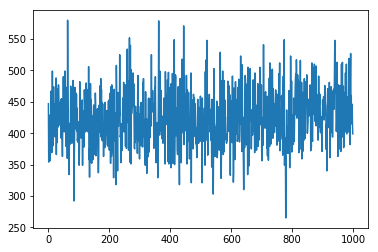

In [6]:
output = np.array(output)
import matplotlib.pyplot as plt
plt.plot(output[:5000,1])